In [1]:
import os
import sys

# Set working directory
plant_clef_root = '/home/ffw/workspace/plantCLEF/'
os.chdir(plant_clef_root)

data_dir = os.path.join(plant_clef_root, 'data')

import numpy as np
import sklearn
import scipy
import scipy.misc
import time
import logging

import matplotlib.pyplot as plt
%matplotlib inline

from utilities import *
import mcl

import caffe
from caffe import layers as L
caffe.set_mode_gpu()

import mcl.nets.scatnet_net
reload(mcl.nets.scatnet_net)
from mcl.nets.scatnet_net import scatnet, gen_prototxt, get_layers_sizes


/home/ffw/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Instantiate network

In [2]:
reload(mcl.nets.scatnet_net)

scale = 2
scales = 2**np.arange(0,scale)
max_order = 2
nangles = 4
filter_size_factor = 2

img_list = os.path.join(plant_clef_root, 'data', 'train.txt')
out_folder = os.path.join(plant_clef_root, 'data', 'train_scat')

In [3]:
def norm(tmp):
    tmp = tmp.copy()
    for l in range(tmp.shape[0]):
        mx = tmp[l].max()
        if mx == 0:
            continue
        if mx == np.inf:
            tmp[l] = 0
            continue
        tmp[l] /= mx
    return tmp

def show_blob(output):
    tmp = output[:,::,::,np.newaxis].copy()
    mask = get_layers_sizes(nangles, max_order, scales, nchannels_input=3)
    tmp = np.concatenate([tmp[mask==0],tmp[mask==1],tmp[mask==2]],3)
    vis_square((tmp[0:]))

def show_output(net, indx=0):
    output = np.squeeze(net.blobs['output'].data[indx,:,:,:])
    show_blob(output)

## Initialize network

In [24]:
image_infos = open(img_list, 'r').read().split('\n')[:1000]
nimages = len(image_infos)

transform_param = dict(mirror=False, crop_size=227)
species_data, species_label = L.ImageData(transform_param=transform_param,
                                          source=img_list,
                                          batch_size=1,
                                          new_height=256,
                                          new_width=256,
                                          ntop=2)

if 'net' in locals():
    del net
net = scatnet(data=species_data, 
              scales=scales, 
              max_order=max_order, 
              nangles=nangles, 
              filter_size_factor=filter_size_factor)

shape = net.blobs['output'].data.shape[1:]
dtype = net.blobs['output'].data.dtype

def run_next():
    i = 0
    while image_infos:    
        info = image_infos.pop(0)
        net.forward()
        output = net.blobs['output'].data.copy()[0,...]
        yield i, info, output
        i += 1
        
mean_coefficients = np.zeros(shape=shape, dtype='float32')
max_coefficients = np.zeros(shape=shape, dtype='float32')
channel_magnitudes = np.zeros((shape[0],nimages))

## Process data

In [107]:
t0 = time.time()
for i, image_info, output in run_next():
    mean_coefficients += output / nimages
    max_coefficients = np.maximum(output, max_coefficients)
    channel_magnitudes[:,i] = np.sqrt(np.sum(np.sum(output**2,1),1))            

    base = os.path.basename(image_info.split()[0])
    label = image_info.split()[1]

    if not i%100:
        msg = "%6i/%6i. %.1f img/sec" % (1+i, nimages, (1+i)/(time.time()-t0))
        print msg

channel_maximum = np.max(np.max(max_coefficients,1),1)
channel_mean = np.mean(np.mean(mean_coefficients,1),1)
channel_magnitude = np.max(channel_magnitudes,1)
magnorm_max_maxcoeff = np.max(channel_maximum / channel_magnitude)

In [128]:
def norm(norm_vec, data, copy=True):
    data = data.copy() if copy else data
    for i, v in enumerate(norm_vec):
        data[i,...] /= v
    return data


def max_norm(*args, **kwargs):
    return norm(channel_maximum, *args, **kwargs)

def max_denorm(*args, **kwargs):
    return norm(channel_maximum**-1, *args, **kwargs)
    
def mag_norm(*args, **kwargs):
    return norm(channel_magnitude, *args, **kwargs)

def magnorm_maxnorm(*args, **kwargs):
    return norm(channel_magnitude * magnorm_max_maxcoeff, *args, **kwargs)
    
#plt.semilogy(channel_maximum)
#plt.semilogy(channel_magnitude)
#plt.semilogy(channel_magnorm_max)

# Visualize data

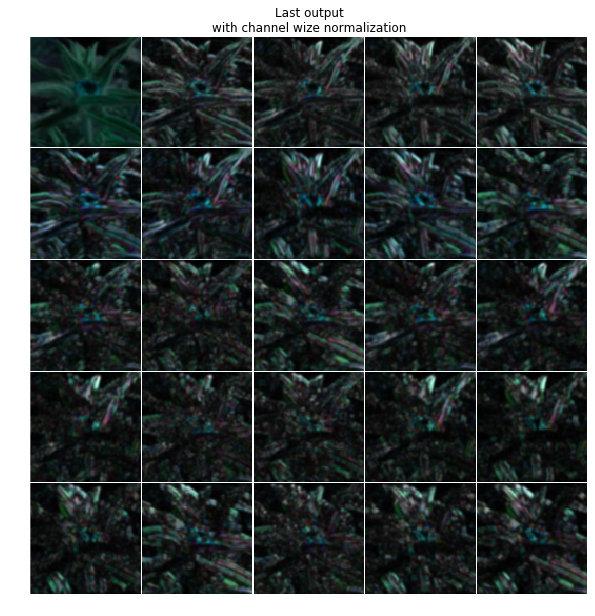

In [129]:
plt.figure(figsize=(10,10))
plt.title('Last output\nwith channel wize normalization')
show_blob(magnorm_maxnorm(output))

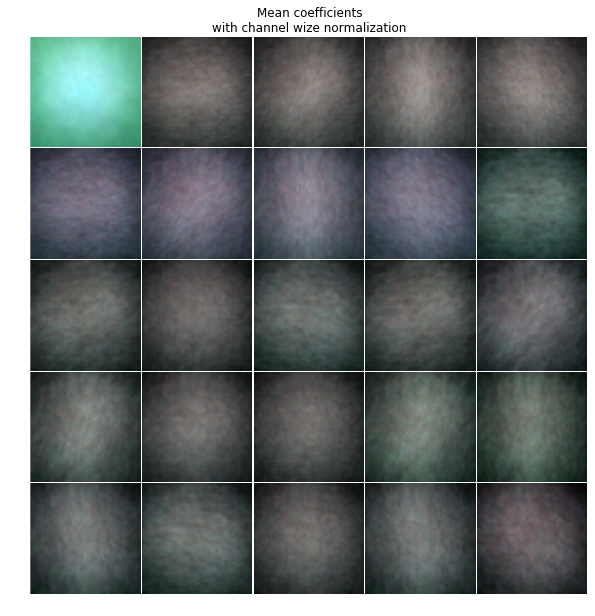

In [130]:
plt.figure(figsize=(10,10))
plt.title('Mean coefficients\nwith channel wize normalization')
show_blob(magnorm_maxnorm(mean_coefficients))

## Convert to `uint8`

In [131]:
output_n = magnorm_maxnorm(output)
mean_coefficients_n = magnorm_maxnorm(mean_coefficients)

output_uint8 = np.float32(np.uint8(255*output_n))/255

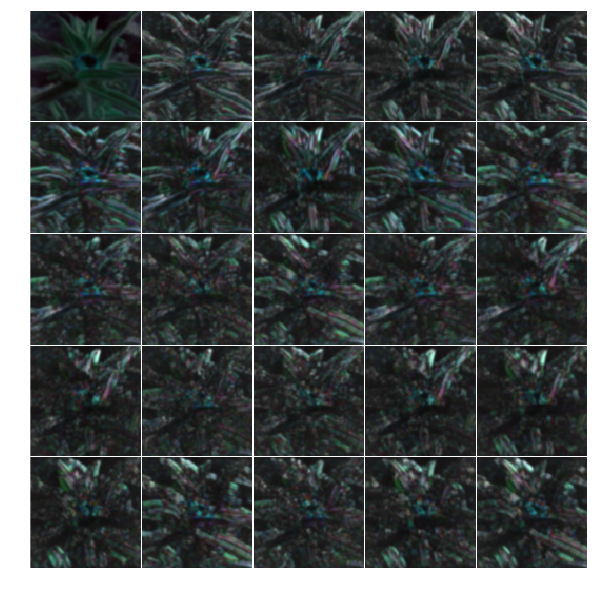

In [132]:
plt.figure(figsize=(10,10))
show_blob(output_uint8-mean_coefficients_n)

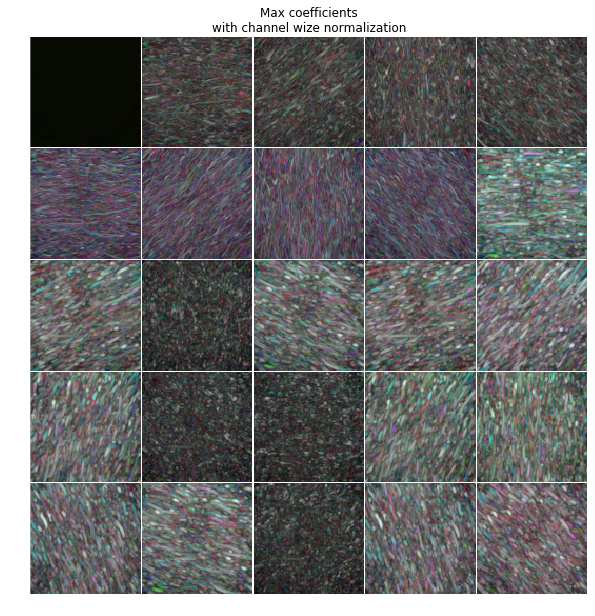

In [117]:
plt.figure(figsize=(10,10))
plt.title('Max coefficients\nwith channel wize normalization')
show_blob(magnorm_maxnorm(max_coefficients))

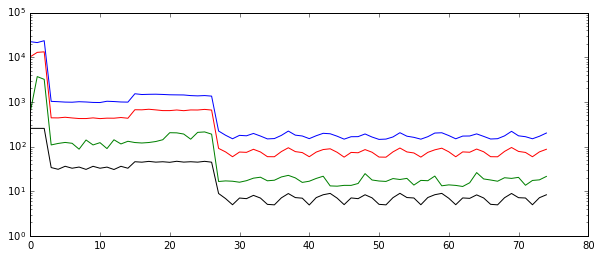

In [96]:

plt.figure(figsize=(10,4))
plt.semilogy(np.max(channel_magnitudes,1))
plt.semilogy(np.min(channel_magnitudes,1))
plt.semilogy(np.mean(channel_magnitudes,1))
plt.semilogy(channel_maximum,'k')


(0, 256)

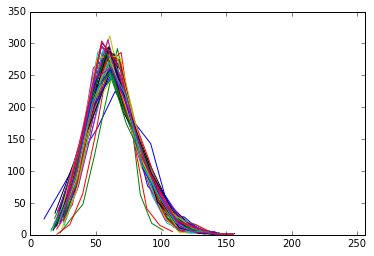

In [98]:
plt.figure()

#hist = lambda i: plt.hist(coeff_magnitudes[:,i] / np.mean(coeff_magnitudes[:,i]))

def hist(i):
    data = channel_magnitudes[i,:].copy()
    data /= np.mean(data)
#    data /= np.var(data)
    data -= 1
    data /= 2    
    data *= 128
    data += 64 
#    data = np.ceil(data)
    y, binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-')
    

for i in range(channel_magnitudes.shape[0]):
    hist(i);
#plt.xlim(-2,2)
plt.xlim(0,256)


In [ ]:
np.mean(coeff_magnitudes.transpose(1,0),1).shape

In [ ]:
np.zeros((3,4)).dtype

In [ ]:
plt.figure(figsize=(10,10))
show_blob(output[0,:,...])

In [ ]:
plt.figure(figsize=(10,10))
show_blob(max_coefficient[0,:,...])

In [ ]:
coeff_power = np.power(mean_coefficient,2)
coeff_sq_sum = np.sum(np.sum(coeff_power,2),2)
coeff_mag = np.sqrt(coeff_sq_sum[0])

plt.figure(figsize=(10,3))
plt.semilogy(coeff_mag)

In [ ]:
image_info

mean_output = os.path.join(plant_clef_root, 'scat_mean.npy')
var_output = os.path.join(plant_clef_root, 'scat_var.npy')

scat_files = !ls /home/ffw/workspace/plantCLEF/data/train_scat/*.scat
nfiles = len(scat_files)


redo_mean_computation = False

if redo_mean_computation: 
    logger.info("Generating mean and var vectors")
    t0 = time.time()
    
    sum_coeff = np.zeros((len(scat_files), shape[1]))
    
    for i, file_path in enumerate(scat_files):
        data = np.fromfile(file_path, dtype=dtype).reshape(shape)    
        data = np.power(data, 2)
        sum_value = np.sum(np.sum(data,2),2)
        sum_value = np.sqrt(sum_value)[0]
        
        sum_coeff[i,:] = sum_value
        
        if not i%1000:
            logger.info("%6i/%6i. %.1f img/sec" % (1+i, nfiles, (1+i)/(time.time()-t0)))
        
    mean_coeff = np.mean(sum_coeff,axis=0)
    var_coeff = np.var(sum_coeff,axis=0)
    scipy.save(mean_output, mean_coeff)
    scipy.save(var_output, var_coeff)

